# Charity Commission register

## Register of merged charities

### Intro

The data can be found at https://www.gov.uk/government/publications/register-of-merged-charities. 

### Imports

In [226]:
import altair as alt

import pandas as pd
import seaborn as sns
from ydata_profiling import ProfileReport

### Cleaning

In [227]:
df = pd.read_csv('../data/mergers_register_march_2024.csv', encoding='cp1252')

In [228]:
df.head()

,Name of transferring charity (transferor) and charity number (if any),Name of receiving charity (transferee) and charity number (if any),Date Vesting Declaration made,Date property transferred,Date merger registered
0,HENRY DREW THOMAS ALMSHOUSE (202453),HENRY DREW THOMAS ALMSHOUSES AND STARCROSS WEL...,NaN,01/03/2023,26/03/2024
1,STARCROSS WELFARE TRUST (205101),HENRY DREW THOMAS ALMSHOUSES AND STARCROSS WEL...,NaN,01/03/2023,26/03/2024
2,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,NaN,31/10/2023,26/03/2024
3,THE ROYAL WELCH FUSILIERS REGIMENTAL COLLECTIO...,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,NaN,31/10/2023,26/03/2024
4,AL-HIJRAH TRUST (1018850),AL-HIJRAH TRUST (1154046),09/11/2022,16/02/2014,25/03/2024


In [229]:
df.dtypes

Name of transferring charity (transferor) and charity number (if any)    object
Name of receiving charity (transferee) and charity number (if any)       object
Date Vesting Declaration made                                            object
Date property transferred                                                object
Date merger registered                                                   object
dtype: object

In [230]:
# shorten col names
df.columns = [
    'transferor', 'transferee', 'date_vesting', 'date_transferred', 'date_registered'
]

In [231]:
# convert first 2 cols to str
df['transferor'] = df['transferor'].apply(str).apply(str.strip)
df['transferee'] = df['transferee'].apply(str).apply(str.strip)

In [232]:
# convert date cols to datetime
date_cols = ['date_vesting', 'date_transferred', 'date_registered']

df[date_cols] = df[date_cols].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

df.head()

,transferor,transferee,date_vesting,date_transferred,date_registered
0,HENRY DREW THOMAS ALMSHOUSE (202453),HENRY DREW THOMAS ALMSHOUSES AND STARCROSS WEL...,NaT,2023-03-01,2024-03-26
1,STARCROSS WELFARE TRUST (205101),HENRY DREW THOMAS ALMSHOUSES AND STARCROSS WEL...,NaT,2023-03-01,2024-03-26
2,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,NaT,2023-10-31,2024-03-26
3,THE ROYAL WELCH FUSILIERS REGIMENTAL COLLECTIO...,ROYAL WELCH FUSILIERS REGIMENTAL MUSEUM TRUST ...,NaT,2023-10-31,2024-03-26
4,AL-HIJRAH TRUST (1018850),AL-HIJRAH TRUST (1154046),2022-11-09,2014-02-16,2024-03-25


In [233]:
df['transferor'].sample(50).str[-15:]

2245     TRUST (802456)
4551     (unregistered)
3241    morgan (260189)
701     tnesses 1067710
3870    e Trust(250084)
4389    sh (1125485-12)
457     tnesses 1065276
750     tnesses 1065266
3626    cuit ( 1133239)
3615    ation (1063283)
2219    S WAY (1173684)
3058    erseas (268094)
2753     Trust (294384)
3210    reland (259688)
1672    tnesses 1065396
3407    ation (1019311)
1320    tnesses 1067382
3263    Bureau (210218)
3002    reach (1027818)
4764    ctuary (255658)
3826     Trust (326012)
1344    tnesses 1067942
3531     (All excepted)
3096    Trust (1103343)
4711     Trust (244610)
507     tnesses 1066001
183     MITED (1008765)
3929    y Hub (1109363)
4715    imited (291080)
4015     Trust (293960)
2325    ' Fund (208671)
3149    s Gift (527099)
383      Help (1154071)
1906    VICES (1096157)
4024    gn UK (1037063)
2074    mouth (1161706)
1736     (Unregistered)
4299    shire (1114895)
162      (Unregistered)
2171    TRUST (1088365)
4025    arity (1085913)
3236    n Hall (

In [236]:
# create charity number cols by extracting contents of last group in parentheses
# and filling any null values with any string of 5+ numbers
df['transferor_number'] = df['transferor'].str.lower().str.extract(
    pat='\(([^\(]+?)\)$'
)
df['transferor_number'] = df['transferor_number'].str.replace(pat='[\-\.\/]', repl='-')
df['transferor_number'] = df['transferor_number'].combine_first(
    df['transferor'].str.extract(pat='(\d{5,})')
)

df['transferee_number'] = df['transferee'].str.lower().str.extract(
    pat='\(([^\(]+?)\)$'
)
df['transferee_number'] = df['transferee_number'].str.replace(pat='[\-\.\/]', repl='-')
df['transferee_number'] = df['transferee_number'].combine_first(
    df['transferee'].str.extract(pat='(\d{5,})')
)

In [237]:
# list values that are not charity numbers
df['transferor_number'].loc[
    ~df['transferor_number'].apply(str).str.contains(r'\d')
].value_counts()

transferor_number
unregistered                                       66
exempt charity                                     16
excepted charity                                    8
unregistered charity                                6
exempt                                              3
excepted                                            3
unincorporated                                      2
unregistered unincorporated charity                 2
unincorporated charity                              1
unrestricted assets only                            1
formerly known as mount zion evangelical church     1
all excepted                                        1
not registered                                      1
herne bay branch                                    1
bottley                                             1
mrs m gee trust                                     1
Name: count, dtype: int64

In [238]:
# standardise values
df['transferor_number'] = df['transferor_number'].replace(
    to_replace={
        'unregistered .*': 'unregistered',
        'exempt .*': 'exempt',
        'excepted .*': 'excepted',
        'unincorporated .*': 'unincorporated',
        'not registered': 'unregistered',
    },
    regex=True
).replace(
    to_replace={
        value: 'other' for value in [
            'unrestricted assets only', 
            'formerly known as mount zion evangelical church',
            'all excepted',
            'herne bay branch',
            'bottley',
            'mrs m gee trust',
        ]
    }
)

df['transferor_number'].loc[
    ~df['transferor_number'].apply(str).str.contains(r'\d')
].value_counts()

transferor_number
unregistered      75
exempt            19
excepted          12
other              6
unincorporated     3
Name: count, dtype: int64

In [239]:
# list values that are not charity numbers
df['transferee_number'].loc[
    ~df['transferee_number'].apply(str).str.contains(r'\d')
].value_counts()

transferee_number
unregistered                         5
exempt charity                       4
incorporating the merrett bequest    1
cio                                  1
excepted                             1
picpus                               1
exempt                               1
Name: count, dtype: int64

In [244]:
# standardise values
df['transferee_number'] = df['transferee_number'].replace(
    to_replace={
        'exempt charity': 'exempt',
        'incorporating the merrett bequest': 'other',
        'cio': 'other',
        'picpus': 'other',
    }
)

df['transferee_number'].loc[
    ~df['transferee_number'].apply(str).str.contains(r'\d')
].value_counts()

transferee_number
exempt          5
unregistered    5
other           3
excepted        1
Name: count, dtype: int64

### Number of mergers over time

#### Most frequent transferors

In [400]:
df['transferor_number'].value_counts()[:10]

transferor_number
unregistered      75
1053467           31
exempt            19
excepted          12
other              6
1189059            5
unincorporated     3
1098026            2
1060621            2
1147851            2
Name: count, dtype: int64

In [398]:
transferor_freqs = df['transferor_number'].value_counts().value_counts().reset_index(name='freqs')

transferor_freqs = transferor_freqs.sort_values(by='count')

transferor_freqs

,count,freqs
0,1,4479
1,2,20
8,3,1
7,5,1
6,6,1
5,12,1
4,19,1
3,31,1
2,75,1


Most transferors are unregistered, exempt, or excepted. This probably indicates that most mergers are of very small charities officially joining bigger ones. 

Most registered transferors have only been in the position of transferring charity once or twice: this makes sense, as a transferor will get merged into the transferee, as a rule.

In [252]:
df[['transferor', 'transferee']].loc[df['transferor'].str.contains('1053467')]

,transferor,transferee
1767,Accident and Emergency Charity (1053467.01),The County Durham and Darlington NHS Foundatio...
1768,Anaesthetics Charity (1053467.02),The County Durham and Darlington NHS Foundatio...
1769,Bequest of Robert Fidderman for the Darlington...,The County Durham and Darlington NHS Foundatio...
1770,Book of Remembrance Charity 1053467.25,The County Durham and Darlington NHS Foundatio...
1771,Business Management Charity (1053467.03),The County Durham and Darlington NHS Foundatio...
1772,Cancer Charity (1053467.04),The County Durham and Darlington NHS Foundatio...
1773,Cardiology Charity (1053467.05),The County Durham and Darlington NHS Foundatio...
1774,Chaplaincy Charity (1053467.06),The County Durham and Darlington NHS Foundatio...
1775,Charitable North Durham Acute 1053467.36,The County Durham and Darlington NHS Foundatio...
1776,Community Health Care North Durham Health Prom...,The County Durham and Darlington NHS Foundatio...


In one case, a number of hospital departments seem to have merged into one entity (*The County Durham and Darlington NHS Foundation Trust Charity*). 

In [253]:
df['transferor'].value_counts()[:10]

transferor
The Parochial Church Council of the Ecclesiastical Parish of The A453 Churches of South Nottinghamshire (1189059)    5
Derbyshire Dales Crossroads Caring for Carers (1098026)                                                              2
Girl Norah                                                                                                           2
Signature Care and Support (1081081)                                                                                 2
South Leicestershire Crossroads Care Attendant Scheme (1062620)                                                      2
Broxtowe Crossroads Limited (1059082)                                                                                2
Positive Pete (1147851)                                                                                              2
The Chronic Granulomatous Disorder Research Trust (1003425)                                                          2
Wigan Advanced Motorists (518387)    

*The Parochial Church Council of the Ecclesiastical Parish of The A453 Churches of South Nottinghamshire* is the most frequent transferor among registered charities, having beein in that position 5 times. 

#### Most frequent transferees

In [401]:
df['transferee_number'].value_counts()[:10]

transferee_number
275946       1281
298028         70
212432         60
1053467        43
801465         40
1125485        35
1004630        17
1051649        16
210202-19      14
1122062        11
Name: count, dtype: int64

In [404]:
transferee_freqs = df['transferee_number'].value_counts().value_counts().reset_index(name='freqs')

transferee_freqs = transferee_freqs.sort_values(by='count')

transferee_freqs

,count,freqs
0,1,2432
1,2,183
2,3,57
3,4,23
4,5,9
5,6,3
6,7,2
8,8,1
7,9,1
18,11,1


In [408]:
chart = (
    alt.Chart(transferee_freqs)
    .mark_bar()
    .encode(
        alt.X('count:Q'),
        alt.Y('freqs:Q')
    )
)

chart

alt.Chart(...)

[]

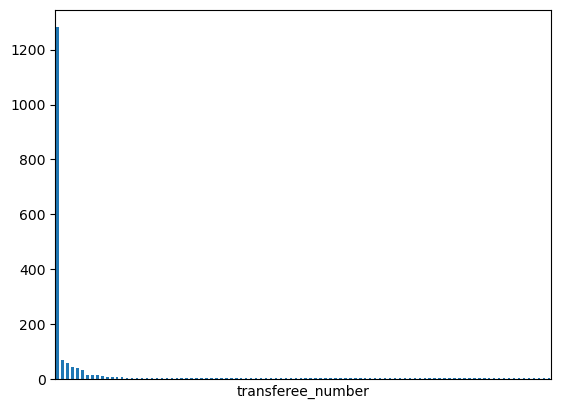

In [257]:
df['transferee_number'].value_counts().iloc[:100].plot(kind='bar').set_xticks([])

Without counting the outlier that merged 1200+ times, some transferees have gone through mergers >40 times. 

Most transferees only go through a merger <5 times.

In [272]:
df['transferee'].value_counts()[:10]

transferee
The Kingdom Hall Trust 275946                                              1279
Victim Support (298028)                                                      70
The Mission to Seafarers (212432)                                            60
The County Durham and Darlington NHS Foundation Trust Charity (1053467)      43
The Merchant Taylors' Schools Crosby (1125485)                               35
Central Hardship and Relief Fund (801465)                                    20
Central Hardship and Relief Trust (CHART) (801465)                           18
UK Community Foundations (1004630)                                           16
Royal Artillery Benevolent Fund (210202-19)                                  14
Bauer Radio's Cash for Kids Charities (1122062)                              11
Name: count, dtype: int64

In [273]:
df[['transferor', 'transferee']].loc[
    df['transferee'].str.contains('Kingdom Hall Trust')
].head()

,transferor,transferee
437,"Hull, Pearson Park Congregation of Jehovah's ...",The Kingdom Hall Trust 275946
453,Aberaeron Congregation of Jehovah's Witnesses...,The Kingdom Hall Trust 275946
454,Aberdare Congregation of Jehovah's Witnesses 2...,The Kingdom Hall Trust 275946
455,Abergavenny Congregation of Jehovah's Witness...,The Kingdom Hall Trust 275946
456,Abertillery Congregation of Jehovah's Witness...,The Kingdom Hall Trust 275946


In [274]:
df[['transferor', 'transferee']].loc[
    df['transferee'].str.contains('Victim Support')
].head()

,transferor,transferee
4180,Bromley Victim Support Scheme (1108399),Victim Support (298028)
4181,Camden Victim Support (1054692),Victim Support (298028)
4182,Lewisham Victim Support Scheme (1042159),Victim Support (298028)
4183,Victim Support County Durham (1090221),Victim Support (298028)
4184,Victim Support Devon (1088440),Victim Support (298028)


In [276]:
df[['transferor', 'transferee']].loc[
    df['transferee'].str.contains('Mission to Seafarers')
].head()

,transferor,transferee
4415,Ada Milligan,The Mission to Seafarers (212432)
4416,Agnes Jones Memorial Fund,The Mission to Seafarers (212432)
4417,Andrew McKee Memorial Fund,The Mission to Seafarers (212432)
4418,Annie Walker,The Mission to Seafarers (212432)
4419,ASM Harris,The Mission to Seafarers (212432)


Summary from a [Brave](https://search.brave.com/search?q=The+Kingdom+Hall+Trust+&summary=1) search:

The Kingdom Hall Trust:
- Previously known as the London Company of Kingdom Witnesses, it was established on 28th July 1939 and changed its name to The Kingdom Hall Trust on 20th June 1994.
- It is a charity associated with Jehovah’s Witnesses, with the charity number GB-CHC-275946.
- The charity has undergone a significant merger in 2022, incorporating 1,279 Jehovah’s Witness congregations into the national charity. This is considered one of the largest charity mergers ever.

#### Count of mergers per year

In [353]:
merger_counts = df.groupby(
    df['date_registered'].dt.year, as_index=True
)['date_registered'].count()

merger_counts = merger_counts.to_frame('count').reset_index()

merger_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
date_registered,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,9,227,375,166,166,163,166,198,163,185,170,130,239,301,293,1588,191,42


In [363]:
chart = (
    alt.Chart(merger_counts)
    .mark_bar()
    .encode(
        alt.Y('date_registered:N', title=''),
        alt.X('count:Q', title=''),
        alt.Color('date_registered:N', legend=None, scale=alt.Scale(scheme='dark2')),
    )
    .properties(
        title='Mergers per year, 11/2007-03/2024',
        width=600
    )
)
chart

alt.Chart(...)